# Which One Doesn't Belong (WODB)

<img src="wodb-simple-1.png" alt="WODB" style="width: 200px;"/>
Which one of the above stands out?

To us pretty clearly the one with the smallest size stands out.

In general, the answer depends on what we can observe and more importantly what we care about.

#### Importing PWE (Possible Worlds Explorer = ASP + Python)

In [1]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.helper import pw_slicer, rel_slicer

In [2]:
%load_ext PWE_NB_Extension

#### Visualization Functions
Here we define some visualization functions and tools to aid us in our analysis.

In [3]:
import networkx as nx

In [4]:
import nxpd
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [5]:
class WODBVizLib:
    
    GRAPHVIZ_PROPERTY_REDIRECTION_DICT = {
        'color': 'fillcolor',
        'size': ['height', 'width'],
    }
    
    GRAPHVIZ_PROPERTY_VALUE_REDIRECTION_DICT = {
        'shape': {
            'square': 'box',
        },
        'height': {
            'large': 2.5,
            'small': 1,
        },
        'width': {
            'large': 2.5,
            'small': 1,
        },
        'style': {
            'bold': '"filled,bold"',
            'thin': 'filled'
        }
    }
    
    @staticmethod
    def create_figure(df, property_name_column='property_name', 
                      property_value_column='property_value', 
                      figID_column='figure_ID', figID=None):
        
        # If multiple figures are in the dataframe, then clip to retain only the required figure
        if figID is not None:
            df = df[df[figID_column] == figID]
        else:
            if len(df) <= 0:
                return None
            figID = df.iloc[0][figID_column]
        
        G = nx.Graph()
        G.add_node(figID)
        
        for i, row in df.iterrows():
            prop_name = row[property_name_column]
            prop_value = row[property_value_column]
            
            if prop_name in WODBVizLib.GRAPHVIZ_PROPERTY_REDIRECTION_DICT:
                prop_name = WODBVizLib.GRAPHVIZ_PROPERTY_REDIRECTION_DICT[prop_name]
            
            if not isinstance(prop_name, list):
                prop_name = [prop_name]
            
            for p in prop_name:
                if (p in WODBVizLib.GRAPHVIZ_PROPERTY_VALUE_REDIRECTION_DICT) \
                and (prop_value in WODBVizLib.GRAPHVIZ_PROPERTY_VALUE_REDIRECTION_DICT[p]):
                    prop_value = WODBVizLib.GRAPHVIZ_PROPERTY_VALUE_REDIRECTION_DICT[p][prop_value]
            
                G.nodes[figID][p] = prop_value
        
        return G

In [6]:
def visualize_figures(propDB_df, property_name_column='property_name', 
                      property_value_column='property_value', 
                      figID_column='figure_ID', figIDs_to_visualize=None, graph_label=" "):
    
    if figIDs_to_visualize is not None:
        propDB_df = propDB_df[propDB_df[figID_column].isin(figIDs_to_visualize)]
    
    propDB_grouped_by_figID = propDB_df.groupby(figID_column)
    figureIDs = list(propDB_grouped_by_figID.groups.keys())
    
    gs = {}
    for figID in figureIDs:
        g = WODBVizLib.create_figure(propDB_grouped_by_figID.get_group(figID), figID=figID, 
                                     property_name_column=property_name_column, 
                                     property_value_column=property_value_column, 
                                     figID_column=figID_column)
        gs[figID] = g
    
    G = nx.union_all(gs.values())
    G.graph['label'] = graph_label
    
    return G
    

def visualize_wodb_query_instance(propDB_df, soln_df, 
                                  property_name_column='property_name', 
                                  property_value_column='property_value', 
                                  figID_column='figure_ID', soln_figID_colum='x1',
                                  graph_label=" "):
    
    G = visualize_figures(propDB_df, property_name_column='property_name', 
                          property_value_column='property_value', 
                          figID_column='figure_ID', graph_label=graph_label)
    
    figIDs_soln = [row[soln_figID_colum] for i, row in soln_df.iterrows()]
    
    for figID in figIDs_soln:
        G.nodes[figID]['label'] = "{}\n(TODB)".format(figID)
    G.graph['forcelabels'] = True
    
    return G

In [7]:
def visualize_figure_from_asp_rules(db_asp_rules, db_rel_name='propDB', db_rel_arity=3, 
                                    property_name_column='property_name', 
                                    property_value_column='property_value', 
                                    figID_column='figure_ID', figIDs_to_visualize=None):
    
    asp_output, md = run_clingo(db_asp_rules)
    pws_rels_dfs, rel_schemas, pw_objects = load_worlds(asp_output, meta_data=md, silent=True)
    propDB_df_rel_name = "{}_{}".format(db_rel_name, str(db_rel_arity))
    propDB_df = pws_rels_dfs[propDB_df_rel_name]
    # Assumes that running the reasoner will only produce one PW (or that atleast all of them have the same DB)
    propDB_df = propDB_df[propDB_df['pw'] == 1]
    
    return visualize_figures(propDB_df, property_name_column=property_name_column, 
                             property_value_column=property_value_column, 
                             figID_column=figID_column, 
                             figIDs_to_visualize=figIDs_to_visualize)

### Property Facts Database

One way to formalize our thinking of the objects we want to analyze is to represent their properties in a DB.

In [8]:
%%clingo --donot-display_input --save_meta_data_to md -lci database_schema --donot-run

% schema propDB(figure_ID, property_name, property_value)

% schema prop(property_name)
prop(X) :- propDB(_,X,_).

In [9]:
%%clingo --donot-display_input -lci fig1 --donot-run

propDB(f1,style,bold).
propDB(f1,color,white).
propDB(f1,size,large).
propDB(f1,shape,square).

We can visualize the figure defined in the cell above using the WODBVizLib defined in the Visualization Functions Section

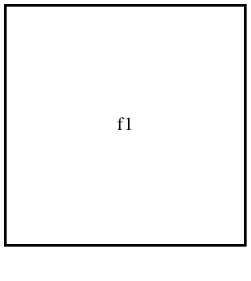

In [10]:
draw(visualize_figure_from_asp_rules("\n".join([database_schema,fig1])))

In [11]:
%%clingo --donot-display_input -lci fig2 --donot-run

propDB(f2,style,bold).
propDB(f2,color,white).
propDB(f2,size,large).
propDB(f2,shape,square).

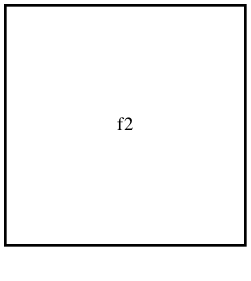

In [12]:
draw(visualize_figure_from_asp_rules("\n".join([database_schema,fig2])))

In [13]:
%%clingo --donot-display_input -lci fig3 --donot-run

propDB(f3,style,bold).
propDB(f3,color,white).
propDB(f3,size,large).
propDB(f3,shape,square).

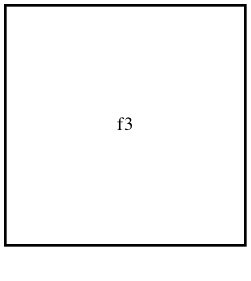

In [14]:
draw(visualize_figure_from_asp_rules("\n".join([database_schema,fig3])))

In [15]:
%%clingo --donot-display_input -lci fig4 --donot-run

propDB(f4,style,bold).
propDB(f4,color,white).
propDB(f4,size,small).
propDB(f4,shape,square).

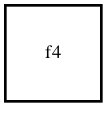

In [16]:
draw(visualize_figure_from_asp_rules("\n".join([database_schema,fig4])))

##### And here's all of them

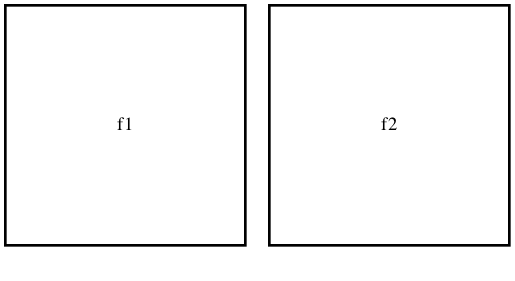

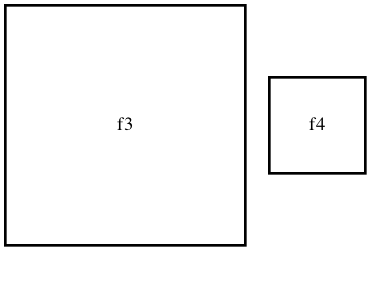

In [17]:
display(draw(visualize_figure_from_asp_rules("\n".join([database_schema,fig1,fig2]))))
display(draw(visualize_figure_from_asp_rules("\n".join([database_schema,fig3,fig4]))))

### Defining Queries to choose TODB (The One that Doesn't Belong)

One formal way to analyze and look for WODB is to use queries, more specifically Datalog/ASP queries.

We explore some such possible queries below.

##### Query: Only one to have a property

In [18]:
%%clingo -lci unique_property_query --donot-display_input --donot-run

% figure F has some value for property P
has_prop(F,P) :- propDB(F,P,_).

% there exists another figure F1 such that both F and F1 have some value for property P
shared_prop(F,P) :- has_prop(F,P), has_prop(F1, P), F != F1.

% choose exactly 1 property to focus on
1 {unique_prop(P) : prop(P)} 1.

% figure F is special wrt property P i.e. no other figure has property P
soln(F,P) :- unique_prop(P), has_prop(F,P), not shared_prop(F,P).

% figure F is special wrt some property
soln(F) :- soln(F,_).

soln_count(N) :-  #count {F: soln(F)} = N.
:- soln_count(N), N <= 0.

In [19]:
%%clingo -l unique_property_query database_schema fig1 fig2 fig3 fig4 --donot-display_input

#show soln/2.
#show soln/1.
#show soln_count/1.
#show unique_prop/1.

Output:


'UNSATISFIABLE\n\nModels       : 0\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

In [20]:
%clingo -l unique_property_query database_schema fig1 fig2 fig3 fig4 --donot-display_input --donot-display_output -exp unique_prop_exp

In [21]:
unique_prop_exp.keys()

dict_keys(['asp_rules', 'asp_soln', 'meta_data'])

In [22]:
unique_prop_exp['pws_rels_dfs'], unique_prop_exp['rel_schemas'], unique_prop_exp['pw_objects'] \
= load_worlds(unique_prop_exp['asp_soln'], meta_data=unique_prop_exp['meta_data'])

The problem is unsatisfiable
Number of Models: 0


In [23]:
unique_prop_exp['pws_rels_dfs'].keys()

dict_keys([])

In [24]:
if 'soln_2' in unique_prop_exp['pws_rels_dfs']:
    display(unique_prop_exp['pws_rels_dfs']['soln_2'])

In [25]:
if len(unique_prop_exp['pw_objects']) > 0:
    for i in range(1, len(unique_prop_exp['pw_objects'])+1):
        pw_i_rels_dfs, _ = pw_slicer(unique_prop_exp['pws_rels_dfs'], None, [i])
        reason_df = pw_i_rels_dfs['soln_2']
        todb_reason = reason_df.iloc[0]['x2']
        g = visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                          pw_i_rels_dfs['soln_1'], 
                                          graph_label='PW-{}: {}'.format(str(i), todb_reason))
        display(draw(g))

Since all the figures have the same set of properties, we cannot make a distinction based on this query in this case.

##### Query: Only one to have a specific value V for property P

In [26]:
%%clingo -lci unique_property_value_query --donot-display_input --donot-run

% figure F and figure F1 both have the same value for their property P
shared_prop(F,F1,P,V) :- propDB(F,P,V), propDB(F1,P,V), F != F1.

% choose exactly 1 property to focus on
1 {unique_prop(P) : prop(P)} 1.

% figure F is unique with respect to property P 
% i.e. no other figure has value V for property P
soln(F,P) :- unique_prop(P), propDB(F,P,_), not shared_prop(F,_,P,_).

% figure F is special wrt some property-value pair
soln(F) :- soln(F,_).

soln_count(N) :-  #count {F: soln(F)} = N.
:- soln_count(N), N <= 0.

In [27]:
%%clingo -l unique_property_value_query database_schema fig1 fig2 fig3 fig4 --donot-display_input

#show soln/2.
#show soln/1.
#show unique_prop/1.
#show soln_count/1.

Output:


'Answer: 1\nsoln(f4,size) soln(f4) soln_count(1) unique_prop(size)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

As we can observe above from the DB and the figures themselves, the only distinguising property is their size.

In [28]:
%clingo -l unique_property_value_query database_schema fig1 fig2 fig3 fig4 --donot-display_input --donot-display_output -exp unique_prop_val_exp

In [29]:
unique_prop_val_exp.keys()

dict_keys(['asp_rules', 'asp_soln', 'meta_data'])

In [30]:
unique_prop_val_exp['pws_rels_dfs'], unique_prop_val_exp['rel_schemas'], unique_prop_val_exp['pw_objects'] \
= load_worlds(unique_prop_val_exp['asp_soln'], meta_data=unique_prop_val_exp['meta_data'])

Number of Models: 1


In [31]:
unique_prop_val_exp['pws_rels_dfs'].keys()

dict_keys(['propDB_3', 'shared_prop_4', 'prop_1', 'soln_2', 'soln_1', 'soln_count_1', 'unique_prop_1'])

In [32]:
unique_prop_val_exp['pws_rels_dfs']['soln_2']

,pw,x1,x2
0,1,f4,size


We can get a visual representation of the solutions (PWs) as below along with the reasoning behind the solution.

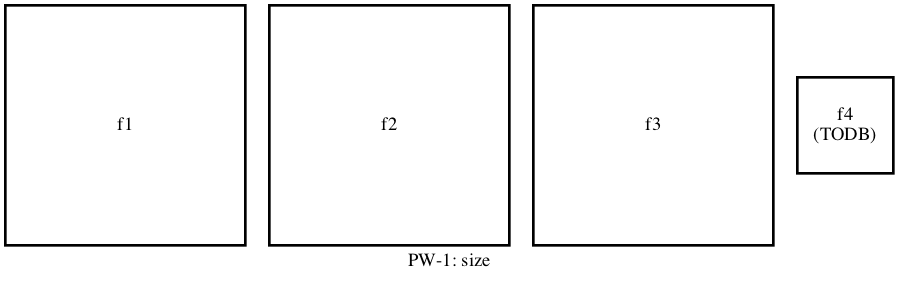

In [33]:
for i in range(1, len(unique_prop_val_exp['pw_objects'])+1):
    pw_i_rels_dfs, _ = pw_slicer(unique_prop_val_exp['pws_rels_dfs'], None, [i])
    reason_df = pw_i_rels_dfs['soln_2']
    todb_reason = reason_df.iloc[0]['x2']
    g = visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                      pw_i_rels_dfs['soln_1'], 
                                      graph_label='PW-{}: {}'.format(str(i), todb_reason))
    display(draw(g))

##### Query: Pick exactly one figure

In [34]:
%%clingo -lci pick_one_fig_query --donot-display_input --donot-run

% choosing criteria could be as simple as choosing exactly one figure
1 {soln(F) : propDB(F,_,_)} 1.

% schema soln_propDB(property_name, property_value)
soln_propDB(P,V) :- soln(F), propDB(F,P,V).

In [35]:
%%clingo -l pick_one_fig_query database_schema fig1 fig2 fig3 fig4 --donot-display_input

#show soln/1.

Output:


'Answer: 1\nsoln(f4)\nAnswer: 2\nsoln(f3)\nAnswer: 3\nsoln(f2)\nAnswer: 4\nsoln(f1)\nSATISFIABLE\n\nModels       : 4\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

Like we desired, the WODB solution is picked to be one of the figures.

In [36]:
%clingo -l pick_one_fig_query database_schema fig1 fig2 fig3 fig4 --donot-display_input --donot-display_output -exp pick_one_exp

In [37]:
pick_one_exp.keys()

dict_keys(['asp_rules', 'asp_soln', 'meta_data'])

In [38]:
pick_one_exp['pws_rels_dfs'], pick_one_exp['rel_schemas'], pick_one_exp['pw_objects'] \
= load_worlds(pick_one_exp['asp_soln'], meta_data=pick_one_exp['meta_data'])

Number of Models: 4


In [39]:
pick_one_exp['pws_rels_dfs'].keys()

dict_keys(['propDB_3', 'prop_1', 'soln_propDB_2', 'soln_1'])

In [40]:
pick_one_exp['pws_rels_dfs']['soln_propDB_2']

,pw,property_name,property_value
0,1,style,bold
1,1,color,white
2,1,shape,square
3,1,size,small
4,2,style,bold
5,2,color,white
6,2,size,large
7,2,shape,square
8,3,style,bold
9,3,color,white


As earlier, we can visualize the solutions.

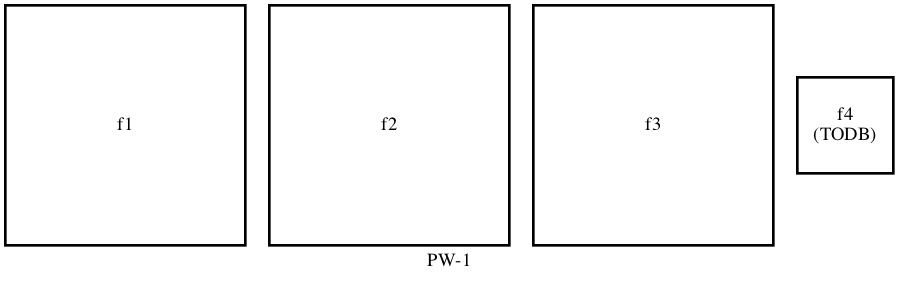

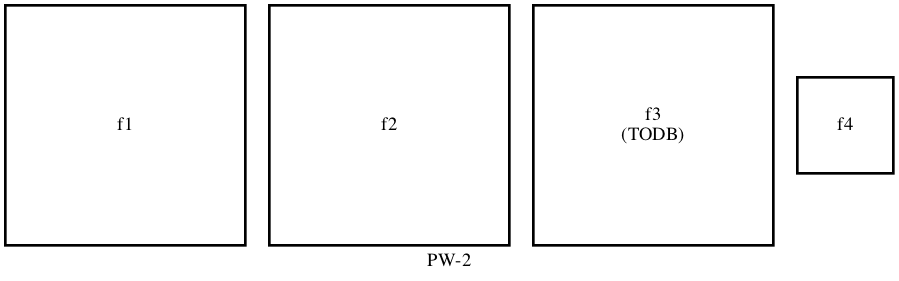

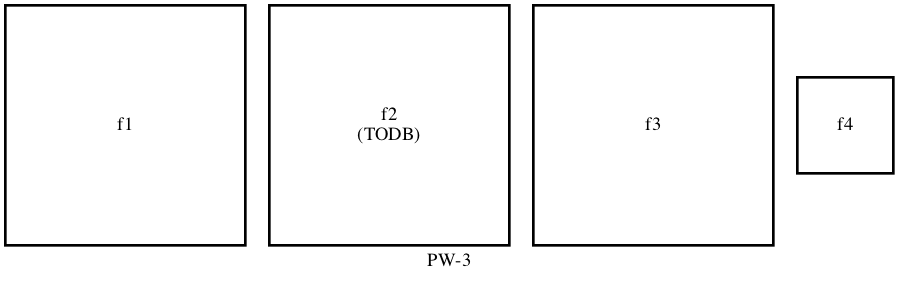

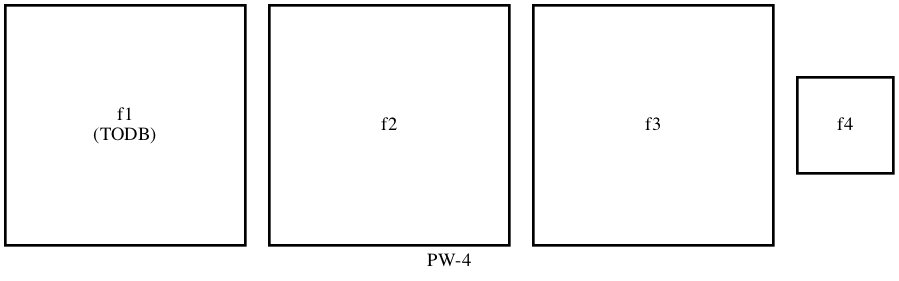

In [41]:
for i in range(1, len(pick_one_exp['pw_objects'])+1):
    pw_i_rels_dfs, _ = pw_slicer(pick_one_exp['pws_rels_dfs'], None, [i])
    g = visualize_wodb_query_instance(pw_i_rels_dfs['propDB_3'], 
                                      pw_i_rels_dfs['soln_1'], 
                                      graph_label='PW-{}'.format(str(i)))
    display(draw(g))

### Finding WODB in Python using PWE

We can also analysis similar to the one above using pure Python and some querying, numerical and visualization tools.

Let's consider each figure to be a PW (Possible World).

##### DB Query Based Analysis (similar to the unique_property_value_query)

In [42]:
from PW_explorer.query import PWEQuery

In [43]:
_ = PWEQuery.unique_tuples(expected_pws=len(pick_one_exp['pw_objects']), 
                           dfs=pick_one_exp['pws_rels_dfs'], 
                           rl_name='soln_propDB_2')

The unique tuple  ('size', 'small') occurs only in PW 1


The above query finds tuples that exists in exactly one PW.

As we can see here, PW-2,3,4 (fig1,2,3) don't have any unique tuples. PW-1 (fig4) is the only one to have a unique tuple.

##### Distance Metric Based Analysis

Distance Metrics can be used to quantify how similar or different two PWs (figures in our case) are. These can be helpful to analyze the solution space and discover existing properties of the same.

In [44]:
import numpy as np
import pandas as pd

In [45]:
from PW_explorer.dist_calc import PWEDistanceCalculation

In our case we use a distance metric based on the size of the symmetric-difference of two PWs.

In [46]:
PWEDistanceCalculation.sym_diff_dist(pw_id_1=1, pw_id_2=2, 
                                     relations=pick_one_exp['rel_schemas'], 
                                     dfs=pick_one_exp['pws_rels_dfs'], 
                                     pws=pick_one_exp['pw_objects'], 
                                     rls_to_use=['soln_propDB_2'])

2

Based on this metric, we can form a distance metric for our set of PWs.

In [47]:
num_pws = len(pick_one_exp['pw_objects'])
dist_matrix = np.zeros((num_pws, num_pws))
for i in range(num_pws):
    for j in range(i+1, num_pws):
        dist_matrix[i][j] = \
            dist_matrix[j][i] = \
                PWEDistanceCalculation.sym_diff_dist(pw_id_1=i+1, pw_id_2=j+1, 
                                                     relations=pick_one_exp['rel_schemas'],
                                                     dfs=pick_one_exp['pws_rels_dfs'],
                                                     pws=pick_one_exp['pw_objects'],
                                                     rls_to_use=['soln_propDB_2'])
        
pd.DataFrame(dist_matrix, index=range(1,len(dist_matrix)+1), columns=range(1, len(dist_matrix)+1))

,1,2,3,4
1,0.0,2.0,2.0,2.0
2,2.0,0.0,0.0,0.0
3,2.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0


We can already see here that while PWs-2,3,4 are all at a distance of 0 from each other (they are all the same), PW-1 is at a distance of 2 from the rest of the PWs.

We can visualize these PWs based on the distance matrix above to get a better visual sense of this.

In [48]:
from PW_explorer.visualize import PWEVisualization

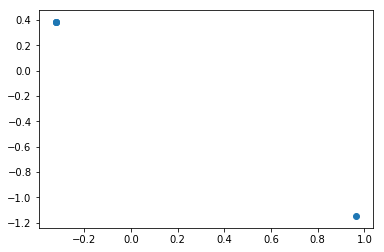

In [49]:
_ = PWEVisualization.mds_sklearn(dist_matrix)

We can clearly see the two clusters as expected.

We can also visualize the distance matrix in more informative and visually appealing ways such as a cluster-map as shown below:

/anaconda3/envs/LeanEuler-prod-env/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


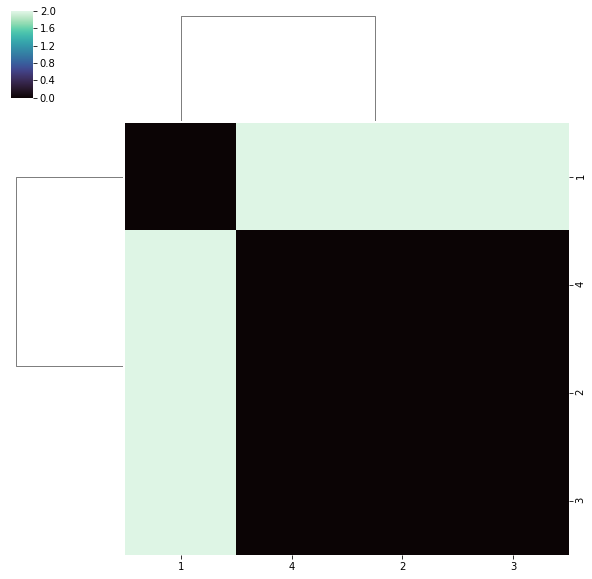

In [50]:
_ = PWEVisualization.cluster_map_viz(dist_matrix)

###### As we can observe, in all of these analyses, PW-1 (fig4) stands out.